# Deep Generative Models - Assignment 2

## Problem 2 - VAE

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms

### Global Parameters

In [ ]:
# latent dimension
z = 10

# training epochs
max_epochs = 100

# batch size
batch_size = 128

# learning rate
learning_rate = 1e-3

# available device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load Dataset

In [ ]:
def get_mnist_data(device, batch_size):

    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST(
            'data', train=True, download=True,
            transform=transforms.ToTensor()
        ),
        batch_size=batch_size, shuffle=True
    )

    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST(
            'data', train=False, download=True,
            transform=transforms.ToTensor()
        ),
        batch_size=batch_size, shuffle=True
    )

    return train_loader, test_loader

train_loader, test_loader = get_mnist_data(device, batch_size)

### Utility Functions

In [ ]:
def sample_gaussian(m, v):
    """
    Element-wise application reparameterization trick to sample from Gaussian

    Args:
        m: tensor: (batch, ...): Mean
        v: tensor: (batch, ...): Variance

    Return:
        z: tensor: (batch, ...): Samples
    """
    z = torch.normal(0, 1, size=v.shape).to(device)
    z = m + torch.sqrt(v) * z
    return z


bce = torch.nn.BCEWithLogitsLoss(reduction='none')

def log_bernoulli_with_logits(x, logits):
    """
    Computes the log probability of a Bernoulli given its logits

    Args:
        x: tensor: (batch, dim): Observation
        logits: tensor: (batch, dim): Bernoulli logits

    Return:
        log_prob: tensor: (batch,): log probability of each sample
    """
    log_prob = -bce(input=logits, target=x).sum(-1)
    return log_prob


def kl_normal(qm, qv, pm, pv):
    """
    Computes the elem-wise KL divergence between two normal distributions KL(q || p) and
    sum over the last dimension

    Args:
        qm: tensor: (batch, dim): q mean
        qv: tensor: (batch, dim): q variance
        pm: tensor: (batch, dim): p mean
        pv: tensor: (batch, dim): p variance

    Return:
        kl: tensor: (batch,): kl between each sample
    """
    element_wise = 0.5 * (torch.log(pv) - torch.log(qv) + qv / pv + (qm - pm).pow(2) / pv - 1)
    kl = element_wise.sum(-1)
    return kl

def log_normal(x, m, v):
    """
    Computes the elem-wise log probability of a Gaussian and then sum over the
    last dim. Basically we're assuming all dims are batch dims except for the
    last dim.

    Args:
        x: tensor: (batch_1, batch_2, ..., batch_k, dim): Observation
        m: tensor: (batch_1, batch_2, ..., batch_k, dim): Mean
        v: tensor: (batch_1, batch_2, ..., batch_k, dim): Variance

    Return:
        log_prob: tensor: (batch_1, batch_2, ..., batch_k): log probability of
            each sample. Note that the summation dimension is not kept
    """
    log_std = torch.log(torch.sqrt(v))
    log_probs = -((x - m) ** 2) / (2 * v) - log_std - np.log(np.sqrt(2 * np.pi))
    log_prob = log_probs.sum(-1)
    return log_prob

def log_mean_exp(x, dim):
    """
    Compute the log(mean(exp(x), dim)) in a numerically stable manner

    Args:
        x: tensor: (...): Arbitrary tensor
        dim: int: (): Dimension along which mean is computed

    Return:
        _: tensor: (...): log(mean(exp(x), dim))
    """
    return log_sum_exp(x, dim) - np.log(x.size(dim))

def log_sum_exp(x, dim=0):
    """
    Compute the log(sum(exp(x), dim)) in a numerically stable manner

    Args:
        x: tensor: (...): Arbitrary tensor
        dim: int: (): Dimension along which sum is computed

    Return:
        _: tensor: (...): log(sum(exp(x), dim))
    """
    max_x = torch.max(x, dim)[0]
    new_x = x - max_x.unsqueeze(dim).expand_as(x)
    return max_x + (new_x.exp().sum(dim)).log()

### Base Models

In [ ]:
class Encoder(nn.Module):

    def __init__(self, z_dim):
        super().__init__()
        self.z_dim = z_dim
        self.net = nn.Sequential(
            nn.Linear(784, 300),
            nn.ELU(),
            nn.Linear(300, 300),
            nn.ELU(),
        )

        self.head_m = nn.Linear(300, z_dim)
        self.head_v = nn.Linear(300, z_dim)

    def forward(self, x):
        h = self.net(x)
        m = self.head_m(h)
        v = self.head_v(h)
        v = F.softplus(v) + 1e-8
        return m, v

In [ ]:
class Decoder(nn.Module):

    def __init__(self, z_dim):
        super().__init__()
        self.z_dim = z_dim
        self.net = nn.Sequential(
            nn.Linear(z_dim, 300),
            nn.ELU(),
            nn.Linear(300, 300),
            nn.ELU(),
            nn.Linear(300, 784)
        )

    def forward(self, z):
        return self.net(z)

### VAE Model

In [ ]:
class VAE(nn.Module):

    def __init__(self, name='vae', z_dim=2):
        super().__init__()
        self.name = name
        self.z_dim = z_dim
        self.encoder = Encoder(self.z_dim)
        self.decoder = Decoder(self.z_dim)

        # Set prior as fixed parameter attached to Module
        self.z_prior_m = torch.nn.Parameter(torch.tensor(0), requires_grad=False)
        self.z_prior_v = torch.nn.Parameter(torch.tensor(1), requires_grad=False)
        self.z_prior = (self.z_prior_m, self.z_prior_v)

    def negative_evidence_lower_bound(self, x):
        """
        Computes the Evidence Lower Bound, KL and, Reconstruction costs

        Args:
            x: tensor: (batch, dim): Observations

        Returns:
            nelbo: tensor: (): Negative evidence lower bound
            kl: tensor: (): ELBO KL divergence to prior
            rec: tensor: (): ELBO Reconstruction term
        """
        m, v = self.encoder(x)
        z = sample_gaussian(m, v)
        logits = self.decoder(z)
        rec = -log_bernoulli_with_logits(x, logits).mean()
        kl = kl_normal(m, v, self.z_prior_m, self.z_prior_v).mean()
        nelbo = kl + rec
        return nelbo, kl, rec

    def negative_iwae_bound(self, x, iw):
        """
        Computes the Importance Weighted Autoencoder Bound
        Additionally, we also compute the ELBO KL and reconstruction terms

        Args:
            x: tensor: (batch, dim): Observations
            iw: int: (): Number of importance weighted samples

        Returns:
            niwae: tensor: (): Negative IWAE bound
            kl: tensor: (): ELBO KL divergence to prior
            rec: tensor: (): ELBO Reconstruction term
        """
        m, v = self.encoder(x)
        m_up = m.unsqueeze(1).repeat(1, iw, 1)
        v_up = v.unsqueeze(1).repeat(1, iw, 1)
        x_up = x.unsqueeze(1).repeat(1, iw, 1)
        z = sample_gaussian(m_up, v_up)
        logits = self.decoder(z)

        log_p_x_g_z = log_bernoulli_with_logits(x_up, logits)
        log_prior_z = log_normal(z, torch.tensor(0), torch.tensor(1))
        log_q_z_g_x = log_normal(z, m_up, v_up)
        log_w = log_p_x_g_z + log_prior_z - log_q_z_g_x
        log_marginal_likelihood = log_mean_exp(log_w, 1).mean()

        niwae = -log_marginal_likelihood
        kl = kl_normal(m, v, torch.tensor(0), torch.tensor(1)).mean()
        rec = -log_p_x_g_z.mean()
        return niwae, kl, rec

    def loss(self, x):
        nelbo, kl, rec = self.negative_evidence_lower_bound(x)
        loss = nelbo

        summaries = dict((
            ('loss', loss.item()),
            ('elbo', -nelbo.item()),
            ('kl_z', kl.item()),
            ('rec', rec.item()),
        ))

        return loss, summaries

    def sample_x(self, batch):
        z = self.sample_z(batch)
        return self.sample_x_given(z)

    def sample_x_given(self, z):
        return torch.bernoulli(self.compute_sigmoid_given(z))

    def sample_sigmoid(self, batch):
        z = self.sample_z(batch)
        return self.compute_sigmoid_given(z)

    def compute_sigmoid_given(self, z):
        logits = self.decoder(z)
        return torch.sigmoid(logits)

    def sample_z(self, batch):
        return sample_gaussian(
            self.z_prior[0].expand(batch, self.z_dim),
            self.z_prior[1].expand(batch, self.z_dim))

### Training

Note that Negative ELBO on the test set should be around 100.

In [ ]:
vae = VAE(z_dim=z).to(device)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

In [ ]:
def vae_train_step(x_batch):

    x_batch = x_batch.reshape(x_batch.shape[0], -1)
    x_batch = x_batch.to(device)
    x_batch = torch.bernoulli(x_batch)

    optimizer.zero_grad()
    loss, summary = vae.loss(x_batch)

    loss.backward()
    optimizer.step()

    return summary

In [ ]:
train_loss, train_kl, train_rec = [], [], []
test_loss, test_kl, test_rec = [], [], []

for epoch in range(max_epochs):

    tmp_loss, tmp_kl, tmp_rec = [], [], []
    for batch_idx, (x_batch, y_batch) in enumerate(train_loader):

        summary = vae_train_step(x_batch)
        tmp_loss.append(summary['loss'])
        tmp_kl.append(summary['kl_z'])
        tmp_rec.append(summary['rec'])

    train_loss.append(np.array(tmp_loss).mean())
    train_kl.append(np.array(tmp_kl).mean())
    train_rec.append(np.array(tmp_rec).mean())

    tmp_loss, tmp_kl, tmp_rec = [], [], []
    for batch_idx, (x_batch, y_batch) in enumerate(test_loader):
        with torch.no_grad():
            x_batch = x_batch.reshape(x_batch.size(0), -1).to(device)
            _, summary = vae.loss(x_batch)

        tmp_loss.append(summary['loss'])
        tmp_kl.append(summary['kl_z'])
        tmp_rec.append(summary['rec'])

    test_loss.append(np.array(tmp_loss).mean())
    test_kl.append(np.array(tmp_kl).mean())
    test_rec.append(np.array(tmp_rec).mean())

    if epoch % 5 == 4:
        print(f'epoch {(epoch+1):3} \t-\t train loss = {train_loss[-1]:.2f} \t-\t test loss = {test_loss[-1]:.2f}')

epoch   5 	-	 train loss = 111.10 	-	 test loss = 111.20
epoch  10 	-	 train loss = 105.60 	-	 test loss = 107.08
epoch  15 	-	 train loss = 103.25 	-	 test loss = 104.88
epoch  20 	-	 train loss = 101.71 	-	 test loss = 103.25
epoch  25 	-	 train loss = 100.68 	-	 test loss = 102.80
epoch  30 	-	 train loss = 99.91 	-	 test loss = 102.48
epoch  35 	-	 train loss = 99.32 	-	 test loss = 101.85
epoch  40 	-	 train loss = 98.82 	-	 test loss = 101.60
epoch  45 	-	 train loss = 98.36 	-	 test loss = 101.36
epoch  50 	-	 train loss = 98.06 	-	 test loss = 100.87
epoch  55 	-	 train loss = 97.76 	-	 test loss = 100.61
epoch  60 	-	 train loss = 97.51 	-	 test loss = 100.52
epoch  65 	-	 train loss = 97.27 	-	 test loss = 100.55
epoch  70 	-	 train loss = 97.08 	-	 test loss = 100.08
epoch  75 	-	 train loss = 96.84 	-	 test loss = 100.13
epoch  80 	-	 train loss = 96.74 	-	 test loss = 100.11
epoch  85 	-	 train loss = 96.61 	-	 test loss = 100.07
epoch  90 	-	 train loss = 96.44 	-	 test l

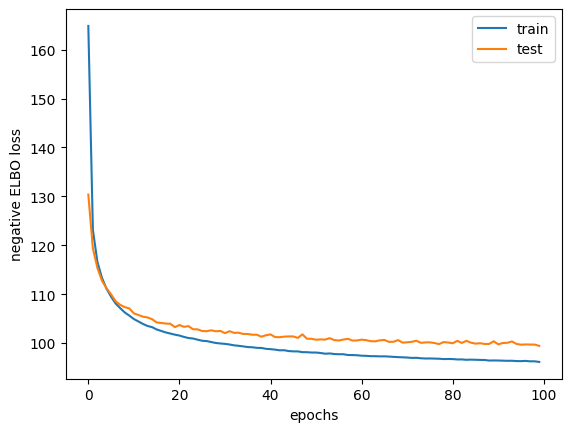

In [ ]:
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.xlabel('epochs')
plt.ylabel('negative ELBO loss')
plt.legend()
plt.show()

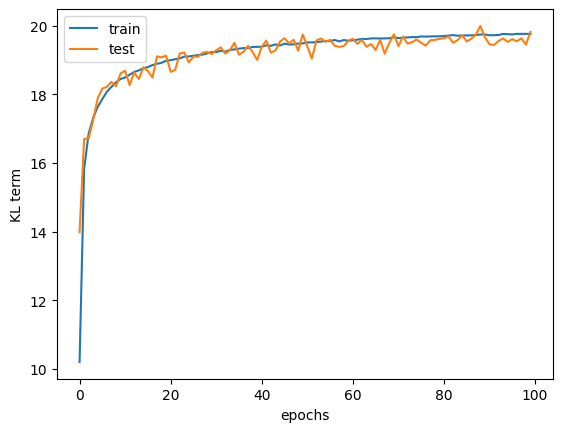

In [ ]:
plt.plot(train_kl, label='train')
plt.plot(test_kl, label='test')
plt.xlabel('epochs')
plt.ylabel('KL term')
plt.legend()
plt.show()

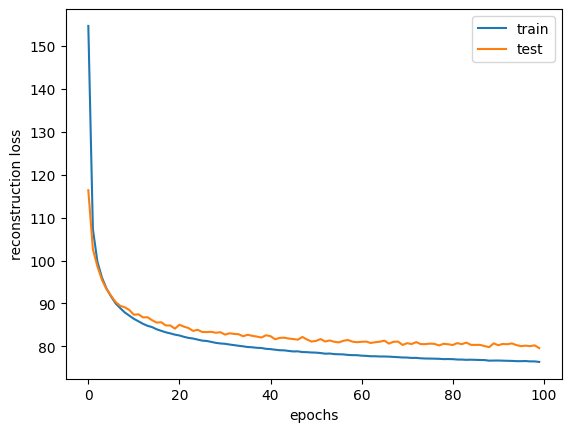

In [ ]:
plt.plot(train_rec, label='train')
plt.plot(test_rec, label='test')
plt.xlabel('epochs')
plt.ylabel('reconstruction loss')
plt.legend()
plt.show()

### Evaluation

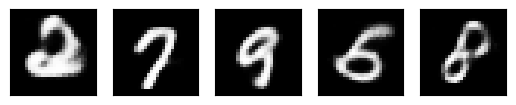

In [ ]:
samples = 5

with torch.no_grad():
    x_hat = vae.sample_sigmoid(samples).cpu().numpy()

x_hat = x_hat.reshape((samples, 28, 28)) * 255
x_hat = x_hat.astype(np.uint8)

fig, axs = plt.subplots(1, samples)
for i in range(samples):
    axs[i].imshow(x_hat[i], cmap='gray')
    axs[i].set_xticks([])
    axs[i].set_yticks([])

plt.show()

In [ ]:
ks = [5, 50, 150]
tmp_loss = []

for batch_idx, (x_batch, y_batch) in enumerate(test_loader):
    x_batch = x_batch.reshape(x_batch.size(0), -1).to(device)

    tmp = []
    for k in ks:
        with torch.no_grad():
            niwae, kl, rec = vae.negative_iwae_bound(x_batch, k)

        tmp.append(niwae.item())

    tmp_loss.append(tmp)

tmp_loss = np.array(tmp_loss).mean(axis=0)

print(f'1- negative ELBO: {test_loss[-1]:.2f}\n')
print('2- negative IWAE bound:\n')
for i, k in enumerate(ks):
    print(f'   k = {k:<3}  :  {tmp_loss[i]:.2f}')

1- negative ELBO: 99.42

2- negative IWAE bound:

   k = 5    :  97.75
   k = 50   :  96.59
   k = 150  :  96.30
